# Машинное обучение, ФКН ВШЭ

## Практическое задание 3

### Общая информация
Дата выдачи: 27.11.2017  

Мягкий дедлайн: 23:59MSK 14.12.2017 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 17.12.2017  

### О задании

Задание состоит из трех независимых разделов, посвященных bias-variance decomposition, решающим деревьям и композициям алгоритмов. Эти разделы можно выполнять в любом порядке. В каждом разделе вам предложена одна или две задачи, которые, в свою очередь, делятся на пункты. Баллы даются за выполнение пунктов, причем в рамках одной задачи пункты, как правило, зависимы (нельзя решить следующий, не решив предыдущего). Пункты могут быть двух видов: написать скрипт или ответить на вопросы. Задачи в рамках одного раздела рекомендуется решать в том порядке, в котором они даны в задании. В разных задачах используются разные наборы данных, все наборы взяты из репозитория UCI или из соревнования с платформы kaggle. 

Задание направлено на более глубокое ознакомление с тем, как работают решающие деревья, случайные леса и как устроено разложение на смещение и разброс. Кроме того, задание предполагает проведение экспериментов и анализ их результатов (мини-исследования). 

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Почта: hse.cs.ml+<номер группы>@gmail.com (например, hse.cs.ml+151@gmail.com для студентов группы БПМИ-151)

Пришлите на почту архив homework-practice-03-Username.zip с выполненным заданием. Архив должен содержать:
* Ноутбук homework-practice-03-Username.ipynb
* Модуль hw3code.py

В контест https://contest.yandex.ru/contest/6469/problems/ нужно отправить файл hw3code.py с реализованными функциями и классами.

Username — ваша фамилия и имя на латинице именно в таком порядке

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

* Ссылка на посылку в Яндекс.Контесте:
* Максимальная оценка: 

1) Максимальная оценка: 10
2) id 9964277

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [8]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [9]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

33.055549208722546

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [10]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

20.169234875485387

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
##### Задача 1. Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [11]:
import seaborn as sns
sns.set(color_codes=True)
from matplotlib import pyplot as plt
%matplotlib inline

In [12]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1. (0.3 балла)__
1. Сгенерируйте выборку $x$ из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных $y$ как сумму $f(x)$ и случайного шума, сгенерированного из равномерного распределения на отрезке $[-1, 1]$ (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: $f(x)$ и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

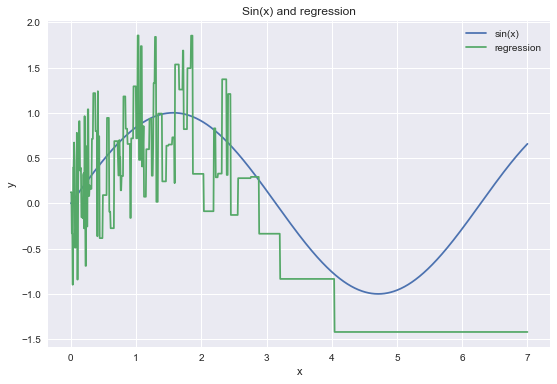

In [13]:
def regress_func(max_depth):
    x = np.random.exponential(size = sample_size)
    y = f(x) + np.random.uniform(low=-1, high=1, size=sample_size) 
    x1 = x[:, np.newaxis]
    linspace1 = linspace[:, np.newaxis]
    from sklearn.tree import DecisionTreeRegressor
    model = DecisionTreeRegressor(max_depth = max_depth)
    model.fit(x1, y)
    preds = model.predict(linspace1)
    return preds

linspace = np.linspace(0, 7, 1000)
plt.figure(figsize = (9, 6))
plt.plot(linspace, f(linspace), label='sin(x)')
plt.plot(linspace, regress_func(None), label='regression')
plt.title('Sin(x) and regression')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.grid()
plt.show()

__2. (0.3 балла)__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

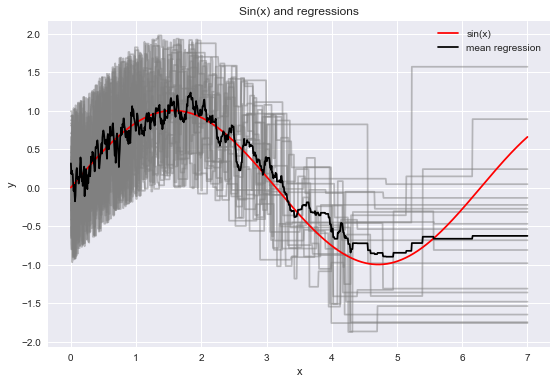

In [14]:
def draw_sin_and_regress(max_depth = None):
    plt.figure(figsize = (9, 6))
    preds_arr = []
    for i in range(samples_num):
        preds = regress_func(max_depth)
        preds_arr.append(preds)
        plt.plot(linspace, preds, color='gray', alpha=0.5)

    preds_mean = np.mean(preds_arr, axis=0)
    plt.plot(linspace, f(linspace), color='red', label='sin(x)')
    plt.plot(linspace, preds_mean, color='black', label='mean regression')
    plt.title('Sin(x) and regressions')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid()
    plt.grid()
    plt.show()
    
draw_sin_and_regress()

__3. (0.1 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика. __Избегайте копипасты кода! Сделайте функцию, параметризованную максимальной глубиной дерева, которая отрисовывает необходимые картинки!__

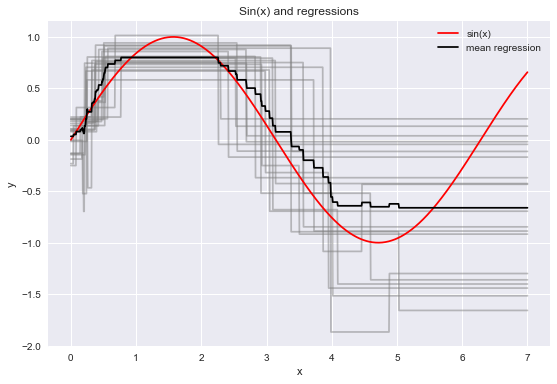

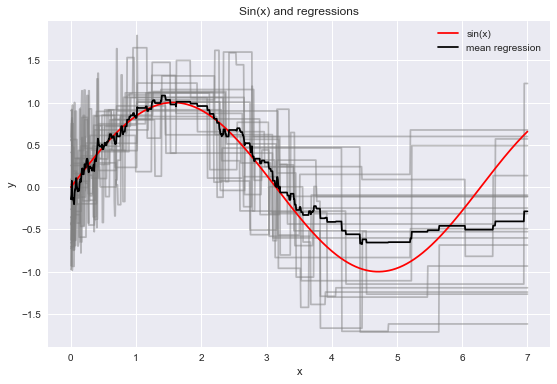

In [15]:
draw_sin_and_regress(max_depth=2)
draw_sin_and_regress(max_depth=4)

__4. (0.3 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

**Ответ:** Чем больше глубина (max_depth) дерева, тем менее оно несмещенное. В нашем случае получилось, что у дерева с max_depth = 4 наименьшее смещение, так как деревьям изначально были поданы зашумленные данные и дерево с max_depth = None поймало шумы и подогналось, а max_depht = 4 не успело подогнаться под шум и, соответсвенно, лучше поймало истинную зависимость sin(x), поэтому оно имеет меньшую смещенность на test. Дерево с максимальной глубиной 2 недостаточно для восстановления истинной зависимости

#### Задача 2. Приближенное оценивание смещения и разброса
Реализуем стохастическую процедуру оценивания смещения и разброса алгоритма.

Будем считать, что каждый объект представлен одним признаком, сгенерированным из некоторого распределения, а значение целевой переменной на этом объекте — это сумма истинного значения функции на объекте + шумовая компонента, также сгенерированная из некоторого распределения.

__5. (1 балл) __ 

Реализуйте функции compute_bias_variance и compute_bias_variance_fixed_samples из модуля hw3code.py

In [29]:
#from importlib import reload
#раелизовано в файле hw3code
import importlib
import hw3code
reload(hw3code)

<module 'hw3code' from 'hw3code.pyc'>

### Посылка Контест: id 9964277

__6. (0.4 балла)__ 

Пусть истинная зависимость данных задается функцией $5\sin (10 x)$, а значения признаков и шум генерируются из одного и того же распределения. Будем пробовать 4 разных распределения и сравнивать 4 регрессионных алгоритма (см. таблицы ниже). Необходимо в каждую ячейку датафреймов bias и variance записать записать соответственно смещение и разброс, рассчитанные для алгоритма, задаваемого строкой таблицы, и генератора случайных чисел, задаваемого столбцом. Остальные параметры функции compute_bias_variance оставьте по умолчанию.

In [30]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

In [31]:
regressors = [LinearRegression(), 
              DecisionTreeRegressor(), 
              RandomForestRegressor(),
              GradientBoostingRegressor()]
generators = [lambda size: np.random.normal(0, 0.3, size=size), 
              lambda size: np.random.exponential(0.3, size=size), 
              lambda size: np.random.uniform(-1, 1, size=size),
              lambda size: np.random.uniform(0, 1, size=size)]

In [32]:
df_bias = pd.DataFrame(columns=["normal(0, 0.3)", "exponential(0.3)", "uniform(-1, 1)", "uniform(0, 1)"],
                       index=["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting"])
df_variance = pd.DataFrame(columns=df_bias.columns, index=df_bias.index)

In [322]:
def custom_func(x):
    return 5*np.sin(10*x)

In [323]:
for i in range(len(regressors)):
    for j in range(len(generators)):
        bias, var = hw3code.compute_bias_variance(regressors[i], custom_func, x_generator=generators[j], noise_generator=generators[j])
        df_bias.iloc[i, j] = bias
        df_variance.iloc[i, j] = var

In [324]:
df_bias

,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,12.1798,7.13028,11.7291,12.0085
DecisionTree,0.0751283,0.0856042,0.00355918,0.000907461
RandomForest,0.0841029,0.128412,0.00388027,0.000933264
GradientBoosting,0.0763127,0.0895467,0.0130303,0.00145208


In [325]:
df_variance

,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,0.0858639,0.0767993,0.0756079,0.05797
DecisionTree,0.171391,0.229553,0.360477,0.0900397
RandomForest,0.0981851,0.132451,0.196533,0.0488269
GradientBoosting,0.1136,0.162136,0.143824,0.0394338


__7. (0.6 балла)__

Проанализируйте полученные таблицы. Ответьте на вопросы:
* Отранжируйте алгоритмы в порядке увеличения разброса (если какие-то алгоримты в разных случаях ранжируются по-разному, поставьте их на одну ступень). Согласуется ли полученный результат с теоретическими рассуждениями из лекций (поясните, почему да или нет)?
* Можно ли сказать, что смещение и разброс алгоритма определяются только самим алгоритмом и не зависят от вероятностной модели данных, к которым этот алгоритм применяется (поясните, почему да или нет)? 
* Для каких распределений смещение решающих деревьев велико (по сравнению с другими распределениями)? Как вы думаете, почему так происходит (какие особенности этих распределений приводят к большому смещению)?

**Ответ:** 
Ответ на вопрос 1): наименьший разборс показывают RF, LinearRegression, GB (в разных случаях разные алгоритмы занимают первое, второе и третье место (см табл)), наибольший разброс демонстрирует дерево, как и предполагалось на лекциях и семинарах, потому что дерево излишне подгоняется под train выборку и будет чуствительно к малейшим изменениям


Ответ на вопрос2): исходя из таблицы видно, что как смещение, так и разброс в разных случаях результаты разные => вероятностная модель также влияет на результат. 


Ответ на вопрос 3): Смещение DecisionTree наибольшее для равномерного и exponential. 

__8. (бонус, 0.5 балла)__

Постройте графики зависимости смещения и разброса от sample_size, samples_num и objects_num (при варьировании одного параметра остальные два остаются по умолчанию) для четырех рассмотренных регрессионных алгоритмов. Сделайте выводы о том, как эти параметры влияют на дисперсию оценок.

### II. Решающие деревья своими руками

#### Задача 3.
В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__9. (0.5 балла)__

Реализуйте функцию find_best_split из модуля hw3code.py

In [36]:
#реализована в hw3code, ранее этот файл заимпортили

__10. (0.5 балла)__

Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [131]:
df = pd.read_csv('students.csv')

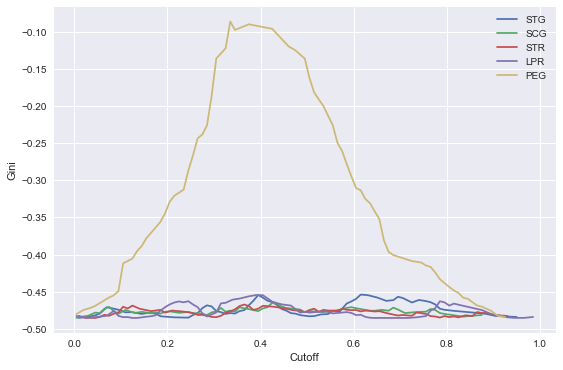

In [142]:
plt.figure(figsize = (9, 6))
for i in range(5): 
    tr, dj, gini_best, threshold_best = hw3code.find_best_split(df[df.columns[i]], df[df.columns[5]]) 
    plt.plot(tr, dj, label=str(df.columns[i])) 
    plt.grid() 
    plt.legend() 
    plt.xlabel('Cutoff') 
    plt.ylabel('Gini')
plt.grid() 

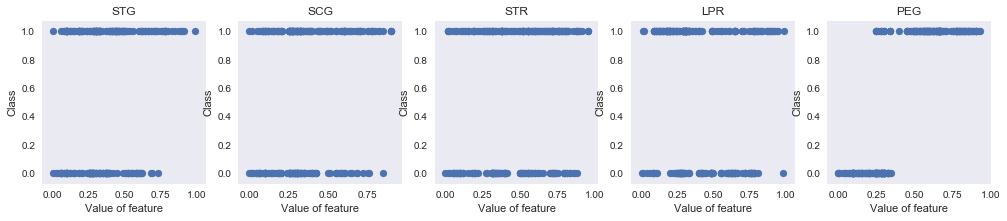

In [39]:
t, ax1 = plt.subplots(1, 5, figsize=(17, 3)) 
for i in range(5): 
    ax1[i].scatter(df[df.columns[i]], df[df.columns[5]]) 
    ax1[i].set_title(str(df.columns[i])) 
    ax1[i].grid() 
    ax1[i].set_xlabel('Value of feature') 
    ax1[i].set_ylabel('Class')

__11. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** исходя из графиков видно, что выгоднее всего делать деление по PEG, так как значение GINI по этому критерию принимает наибольшее значение. Это совпадает и со scater графиком - классы практически идеально делятся.
Кривая для "хороших" признаков должна быть похожа на некую параболу: сначала возрастать (пока отсекаем только элементы одного класса), а после убывать (когда начинаем отсекать влево элементы другого класса).
Кривые для "плохих" признаков должны несильно меняться, то есть быть близки к некой горизонтальной прямой

__12. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw3code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

In [40]:
#реализована в hw3code, ранее этот файл заимпортили

__13. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [68]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

In [119]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
df = pd.read_table(url, sep=',', header=None)

le = LabelEncoder()
df = df.apply(le.fit_transform)
y = df[0]
X = df[df.columns[1:]]
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

a=["real"] * X_train.shape[1]
dt = hw3code.DecisionTree(feature_types = a)
dt.fit(X_train, y_train)
accuracy_score(y_test, dt.predict(X_test))

1.0

Действительно получили значение accuracy = 1

__14. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__15. (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [121]:
url="https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data"
df = pd.read_table(url, sep=',', header=None)
df = df.apply(le.fit_transform)
tic_tac_x = df[df.columns[:df.shape[1]-1]]
tic_tac_y = df[df.columns[-1]]

url="https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
df = pd.read_table(url, sep=',', header=None)
cars_y = df[df.columns[-1]].apply(lambda x: 0 if x=='unacc' or x=='acc' else 1)
cars_x = df[df.columns[:df.shape[1]-1]].apply(le.fit_transform)

url="https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data"
df = pd.read_table(url, sep=',', header=None)
nursery_y = df[df.columns[-1]].apply(lambda x: 0 if (x=='not_recom' or x=='recommend') else 1)
nursery_x = df[df.columns[:df.shape[1]-1]].apply(le.fit_transform)

In [120]:
mushrooms_x = X
mushrooms_y = y

In [170]:
final_score_accuracy = pd.DataFrame(columns=["real", "categorical", "one_hot", "sklearn"],
                       index=["mushrooms", "tic_tac", "cars", "nursery"])

In [171]:
tables = [[mushrooms_x, mushrooms_y], [tic_tac_x, tic_tac_y], [cars_x, cars_y], [nursery_x, nursery_y]]

In [172]:
def cv_for_table(dt, tables):
    return np.mean(cross_val_score(dt, np.array(tables[0]), np.array(tables[1]), cv=10, scoring=make_scorer(accuracy_score)))

In [173]:
#sklearn
dt = DecisionTreeClassifier(random_state=42)
for i in range(4):
    final_score_accuracy.iloc[i]['sklearn'] = cv_for_table(dt, tables[i])

In [174]:
# real:
for i in range(4):
    dt1 = hw3code.DecisionTree(feature_types = ["real"] * tables[i][0].shape[1])
    final_score_accuracy.iloc[i]['real'] = cv_for_table(dt1, tables[i])

In [175]:
# One-hot:
enc = OneHotEncoder(sparse=False)
mushrooms_x_new = pd.DataFrame(enc.fit_transform(mushrooms_x))
tic_tac_x_new = pd.DataFrame(enc.fit_transform(tic_tac_x))
cars_x_new = pd.DataFrame(enc.fit_transform(cars_x))
nursery_x_new = pd.DataFrame(enc.fit_transform(nursery_x))

tables_new = [[mushrooms_x_new, mushrooms_y], [tic_tac_x_new, tic_tac_y], [cars_x_new, cars_y], [nursery_x_new, nursery_y]]
for i in range(4):
    dt2 = hw3code.DecisionTree(feature_types = ["real"] * tables_new[i][0].shape[1])
    final_score_accuracy.iloc[i]['one_hot'] = cv_for_table(dt2, tables[i])

In [176]:
#Categorical:
for i in range(4):
    dt3 = hw3code.DecisionTree(feature_types = ["categorical"] * tables[i][0].shape[1])
    final_score_accuracy.iloc[i]['categorical'] = cv_for_table(dt3, tables[i])

In [177]:
final_score_accuracy

,real,categorical,one_hot,sklearn
mushrooms,0.999261,0.999754,0.999261,0.961853
tic_tac,0.466491,0.488421,0.466491,0.748024
cars,0.942647,0.937996,0.942647,0.94039
nursery,0.999691,0.999846,0.999691,0.999691


__16. (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:** исходя из таблицы видим, что алгоритмы по-разному разжируются на разных данных. Связано это с тем, что всё же качество зависит от датасета. К тому же применение One-Hot кодирования может быть как полезно для решения задачи, так и нет. В частности, для порядковых переменных следует применять Label encoder, для остальных следует делать dummy переменные. Случайная компонента есть, напрмиер, если разные сплиты дают одинаковое значение критерия, то алгортим выбирает какой-то по порядку, а так он все время перемешивает признаки, и этот первый оказывается разным. Влиять на неё можно, но навряд ли это улучшит качество алгоритма, посколько если одинаковые сплиты дают одно и то же значение критерия, то нам всё равно как разбивать и мы не знаем как это будет вести себя на test выборке

### III. Композиции деревьев
#### Задача 4. Сравнение композиционных методов над решающими деревьями
__17. (0.5 балла)__

Загрузите датасет из соревнования [BNP Paribas Cardif Claims Management](https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/leaderboard). Возьмите из него первые 10к объектов, оставьте только вещественные признаки, а пропуски замените нулями. Разбейте выборку на обучение и контроль в соотношении 7:3.

1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов на обучающей выборке:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом (если это не так, то посмотрите как ведут себя алгоритмы с разными сидами в кроссвалидации и самих алгоритмах). Этот пример демонстрирует, что RandomForest — это более сложный алгоритм, чем бэггинг. 

In [281]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [282]:
data = pd.read_csv('train.csv')
data = data[:10000]
data.fillna(value=0, inplace=True)

In [283]:
data = data[data.columns[np.where(data.dtypes!='object')]]

In [284]:
target = data['target']
data = pd.DataFrame(data.drop('target', axis=1))
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

In [285]:
X_train.head()

,ID,v1,v2,v4,v5,v6,v7,v8,v9,v10,...,v121,v122,v123,v124,v126,v127,v128,v129,v130,v131
5099,10178,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.625821,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
5806,11559,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.553611,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
7504,14995,2.448530,2.374558,2.249082,2.486855,1.294118,1.404412,1.971913,4.823009,1.291028,...,6.656977,2.876106,11.256539,0.858095,1.845276,2.467831,0.100454,0,6.094240,1.237113
9929,19807,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.050328,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
4612,9200,5.255681,9.101184,5.491266,9.556154,1.704545,2.670454,0.012943,7.586208,2.625821,...,2.040816,5.517241,2.605493,0.004947,1.604904,1.491478,3.485130,0,1.617021,5.263158


In [292]:
dt = DecisionTreeClassifier(random_state=13)
dt_result = cross_val_score(dt, X_train, y_train)

bag = BaggingClassifier(n_estimators=100, random_state=13)
bag_result = cross_val_score(bag, X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=13)
rf_result = cross_val_score(rf, X_train, y_train)

In [294]:
print 'Decision tree, kfolds=3, mean_Accuracy_cv = ', np.mean(dt_result)
print 'bagging, kfolds=3, mean_Accuracy_cv = ', np.mean(bag_result)
print 'RF, kfolds=3, mean_Accuracy_cv = ', np.mean(rf_result)

Decision tree, kfolds=3, mean_Accuracy_cv =  0.657714678923
bagging, kfolds=3, mean_Accuracy_cv =  0.744999590903
RF, kfolds=3, mean_Accuracy_cv =  0.749713387452


Как и предполагалось в задаче - лучше всех сработал RF, потом бэггинг и последнее место DecisionTree

#### Задача 5. Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__18. (0.5 балла)__

Переберите значения от 20 до 1000-5000 деревьев с шагом 20, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $20 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [295]:
number_of_tree = np.arange(20, 1000, 20)
results = []
rf = RandomForestClassifier(n_estimators=10, random_state=1, warm_start=True)
rf.fit(X_train,y_train)
for i in number_of_tree:
    params = {'n_estimators': i}
    rf.set_params(**params)
    rf.fit(X_train,y_train)
    results.append(accuracy_score(y_test,rf.predict(X_test)))
best_RF_result = np.max(results)

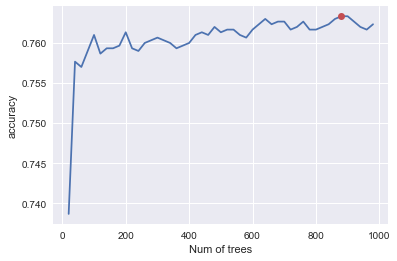

In [296]:
plt.plot(number_of_tree, results)
plt.plot(number_of_tree[np.argmax(results)], best_RF_result, 'ro')
plt.grid()
plt.xlabel('Num of trees')
plt.ylabel('accuracy')
plt.grid()

In [297]:
print 'Best_param_num_of_trees:', number_of_tree[np.argmax(results)]

Best_param_num_of_trees: 880


Не наблюдаем переобучения, что соответсвует нашим предположениям с лекций и семинаров

#### Задача 6. Обучение градиентного бустинга

__19. (1 балл)__

А теперь попробуйте обучить на тех же данных xgboost — одну из реализаций градиентного бустинга. Подберите параметры на обучающем множестве с помощью кроссвалидации (хорошая [статья](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) про тюнинг параметров xgboost). 

In [298]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

Согласно статье: рекомендуется взять learning_rate = 0.1, а после подбора всех параметров попробуем его подобрать

In [310]:
#max_depth и n_estimators
xg1 = xgb.XGBClassifier(seed=134, learning_rate=0.1)
parameters = {'n_estimators':np.arange(10, 210, 50), 'max_depth':np.arange(2,8,2)}
XG1 = GridSearchCV(xg1, parameters,cv=3, scoring='f1')
XG1.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=134, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 10,  60, 110, 160]), 'max_depth': array([2, 4, 6])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [311]:
XG1.best_params_

{'max_depth': 2, 'n_estimators': 60}

In [312]:
#регуляризация
xg2 = xgb.XGBClassifier(seed=134, learning_rate=0.1, n_estimators=XG1.best_params_['n_estimators'], 
                        max_depth=XG1.best_params_['max_depth'])
parameters = {'reg_alpha': 0.1**np.arange(6)}
XG2 = GridSearchCV(xg2, parameters, cv=3, scoring='f1')
XG2.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=60, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=134, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'reg_alpha': array([  1.00000e+00,   1.00000e-01,   1.00000e-02,   1.00000e-03,
         1.00000e-04,   1.00000e-05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [314]:
XG2.best_params_

{'reg_alpha': 0.0010000000000000002}

In [315]:
#min_child_weight и gamma:
parameters = {'min_child_weight' : np.arange(1, 10, 2), 'gamma':[0.1, 0.3, 0.4, 0.7, 0.9]}
xg3 = xgb.XGBClassifier(seed=134, learning_rate=0.1, n_estimators=XG1.best_params_['n_estimators'], 
                        max_depth=XG1.best_params_['max_depth'], reg_alpha=XG2.best_params_['reg_alpha'])
XG3 = GridSearchCV(xg3, parameters, cv=3, scoring='f1')
XG3.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=60, nthread=-1,
       objective='binary:logistic', reg_alpha=0.0010000000000000002,
       reg_lambda=1, scale_pos_weight=1, seed=134, silent=True,
       subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': [0.1, 0.3, 0.4, 0.7, 0.9], 'min_child_weight': array([1, 3, 5, 7, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [316]:
XG3.best_params_

{'gamma': 0.7, 'min_child_weight': 5}

In [317]:
#learning rate
xg4 = xgb.XGBClassifier(seed=134, n_estimators=XG1.best_params_['n_estimators'],
                        max_depth = XG1.best_params_['max_depth'], reg_alpha = XG2.best_params_['reg_alpha'], 
                        gamma= XG3.best_params_['gamma'], min_child_weight=XG3.best_params_['min_child_weight'])
parameters = {'learning_rate' : np.logspace(-8, 1, 8)}
XG4 = GridSearchCV(xg4, parameters, cv=3, scoring='f1')
XG4.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.7, learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=5, missing=None, n_estimators=60, nthread=-1,
       objective='binary:logistic', reg_alpha=0.0010000000000000002,
       reg_lambda=1, scale_pos_weight=1, seed=134, silent=True,
       subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': array([  1.00000e-08,   1.93070e-07,   3.72759e-06,   7.19686e-05,
         1.38950e-03,   2.68270e-02,   5.17947e-01,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [318]:
XG4.best_params_

{'learning_rate': 0.026826957952797274}

In [326]:
best_XGB_result = accuracy_score(y_test, XG4.predict(X_test))
print 'Accuracy XG:', best_XGB_result

Accuracy XG: 0.761


__20. (бонус, 1 балл)__

_В этом и следующем бонусе можете использовать либо теже 10к первых объектов, либо полную выборку._

Теперь вспомним, что изначально выбросили все категориальные признаки из датасета. Добавьте категориальные признаки с количеством уникальных значений < 50 тремя способами:
* как OHE признаки
* как порядковые признаки (закодируйте с помощью LabelEncoder, порядок случайный)
* как счетчики со сглаживанием

Подберите в каждом из случаев оптимальные параметры метода. Как вы думаете, должна ли меняться оптимальная глубина деревьев от способа кодирования категориальных признаков? Согласуется ли это с экспериментом? Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? 

__21. (бонус, 1 балл)__

Попробуйте пообучать на этих же данных другие реализации градиентного бустинга – catboost и lgbm. Подберите для них оптимальные параметры. Удалось ли достичь качества лучше, чем у xgboost? Сравните время обучения всех трех реализаций.

### IV. P. S.
Если вы добрались до этой ячейки, то скорее всего, вы очень устали и хотите... впрочем, каждый в данной ситуации хочет что-то свое :) Так или иначе, здесь вы можете написать фидбек по заданию: указать, с чем возникли проблемы, что оказалось самым сложным, а что — простым, как можно усовершенствовать задание в будущем. Или просто поделитесь мнением о том, какой фактор будет самым важным при сдаче экзамена по курсу.

__22. (бонус, 0.2 балла)__ А еще, вставьте нарисованную вами смешную картинку.

In [79]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://pp.userapi.com/c841135/v841135423/589a1/GdjCcHPHLeI.jpg")

(・・ ) ?